# DQNを利用したデータ作成

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
from IPython.display import clear_output
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
import pandas as pd
import time


physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True


In [2]:
#ボードの形状
width = 7
height = 6


win_num = 4

#loop回数
loop_limit = 20000
#戻る手数
back_step = 6
#戻る回数
back_limit = 5

alpha = 0

In [3]:
#モデルの形
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(height * width,), name='flatten_layer'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(256, activation='tanh'),
    
#    tf.keras.layers.Dense(256, activation='tanh'),
#    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='tanh')
], name='my_model')
#モデルの学習プロセス
model.compile(optimizer='adam',
              loss='mse')



In [4]:
#盤面の初期化
def initalize_playboard():
    board = [0 for i in range(width  * height)]
    return board

#推移可能な盤面の一覧
def make_next_playboard_candidate(input_playboard,input_player):
    return_board = []
    for i in range(width):
        temp_num = width * (height - 1) + i
        while input_playboard[temp_num] != 0:
            temp_num -= width
            if temp_num < 0:
                break
        
        if temp_num >= 0:
            temp_board = copy.deepcopy(input_playboard)
            temp_board[temp_num] = input_player
            return_board.append(temp_board)
            
    return return_board



#確実に勝つ手があるかを模索．あるならその手を打つ．
def surely_win_board_func(input_playboard):
    for board_ in input_playboard:
        if win_or_not(board_):
            return board_
    return False

#勝ち負けの判断を行う．
def win_or_not(input_playboard):
    #縦のジャッジ
    for i in range(width):
        temp_counter = 0
        for j in range(height):
            if input_playboard[i + width * j] == 1:
                temp_counter += 1
                if temp_counter >= win_num:
                    return True
            
            else:
                temp_counter = 0

        
    #横のジャッジ
    for j in range(height):
        temp_counter = 0
        for i in range(width):
            if input_playboard[i + width * j] == 1:
                temp_counter += 1
                if temp_counter >= win_num:
                    return True
            else:
                temp_counter = 0
            


    #右上ななめのジャッジ
    for i in range(width - win_num + 1):
        for j in range(height - win_num + 1):
            temp_counter = 0
            start_index = (win_num - 1) + i + j * width
            while temp_counter < win_num:
                if input_playboard[start_index] == 1:
                    temp_counter += 1
                    start_index += (width - 1)
                else:
                    temp_counter = 100
            if temp_counter != 100:
                return True
            
    #左上ななめのジャッジ
    for i in range(width - win_num + 1):
        for j in range(height - win_num + 1):
            temp_counter = 0
            start_index = i + j * width
            while temp_counter < win_num:
                if input_playboard[start_index] == 1:
                    temp_counter += 1
                    start_index += (width + 1)
                else:
                    temp_counter = 100
            if temp_counter != 100:
                return True
    return False
        
    
    
#ここに置くと次の相手のターンで確実に負けるという手を除く．
def surely_lose_func(input_playboard_candidate):
    
    temp_array = copy.deepcopy(input_playboard_candidate)
    return_lose_array = []
    return_win_array = []
    for board_ in temp_array:
        temp_board = [-1 * board_[i] for i in range(width * height)]
        temp_board_next_candidate = make_next_playboard_candidate(temp_board,1)
        temp_ = surely_win_board_func(temp_board_next_candidate)
        if temp_:
            return_lose_array.append(board_)
            return_win_array.append(temp_)
    return return_lose_array,return_win_array


#最も盤面価値が高いと予測される盤面を返す．
def return_most_Q_func(input_board_array):
    temp_ = np.array(copy.deepcopy(input_board_array))
    temp_ = [conv_board_to_analyze(temp_[i]) for i in range(len(input_board_array))]
    Q_value_array = model.predict(np.array(temp_))
    Q_value_array = Q_value_array.flatten()
    Q_value_array = list(Q_value_array)

    return input_board_array[Q_value_array.index(max(Q_value_array))]
        
    
#盤面データをニューラルネットワークに入れられるように変換．CNNなどの場合用
def conv_board_to_analyze(input_playboard):
    return input_playboard



def chosen_data_func(input_board,input_Q):
    
    return_board = []
    return_Q = []
    for i in range(len(input_board)):
        #後半のデータ量を増すために石が多い盤面に関しては保存確率を上げる．
        if math.exp(-((0.2 + max(height * width -  input_board[i].count(0) + 1 - win_num * 2,0)) / 50)) <= random.random():
            return_board.append(input_board[i])
            return_Q.append(input_Q[i])
    return return_board,return_Q
       
#盤面の可視化
def view_map(input_playboard):
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes()
    for j in range(height):
        for i in range(width):
            if input_playboard[i + j * width] == 0:
                c = patches.Circle(xy=(i * 10, (height - j) * 10), radius=5, fc='w', ec='k')
                ax.add_patch(c)
            elif input_playboard[i + j * width] == 1:
                c = patches.Circle(xy=(i * 10, (height - j) * 10), radius=5, fc='r', ec='k')
                ax.add_patch(c)    
            elif input_playboard[i + j * width] == -1:
                c = patches.Circle(xy=(i * 10, (height- j ) * 10), radius=5, fc='b', ec='k')
                ax.add_patch(c)
            else:
                print("Error")
                break



    plt.axis('scaled')
    ax.set_aspect('equal')
    plt.show()

In [6]:
loop_counter = 0
analyze_count_array = [0 for _ in range(width * height + 1)]
analyze_board = []
analyze_Q_value = []


back_counter = back_limit

#実際の試合データを収集し，そのデータから各盤面のQ値の教師データを収集．

while True:
    
    
    
    back_counter += 1
    #ランダムに手を打つ確率
    if random.random() <= alpha:
        epsilon = 0
    else:
#        epsilon = 1
        epsilon = 0.75 *  (1 - max(0,(loop_counter - (loop_limit / 10)) / loop_limit)) + 0.05    
        
    #もし規定回数以上back_stepを繰り返していたら，一から試合を開始する．
    if back_limit < back_counter:

        
        
        if loop_counter != 0:
            #データ量を減らす
            chosen_board_data,chosen_Q_data = chosen_data_func(all_board_data,all_Q_data)

            for data_index_ in range(len(chosen_board_data)):
                analyze_count_array[height * width - chosen_board_data[data_index_].count(0)] += 1
                analyze_board.append(conv_board_to_analyze(chosen_board_data[data_index_]))
                analyze_Q_value.append(chosen_Q_data[data_index_])             
            #ニューラルネットワークの更新．集まったデータを元に基本方針をより良いものにすることで，より意味のある教師データを収集する．
            if loop_counter % (loop_limit // 200) == 0:
                pass
                print("========================")   
                print(len(analyze_board),len(analyze_Q_value))
                model.fit(np.array(analyze_board),np.array(analyze_Q_value),batch_size=int(2 ** ((math.log2(len(analyze_board))-4) // 1)),epochs=10)

                print(loop_counter)
                print(analyze_count_array)
                print(datetime.datetime.now())
                print("========================")
            
            
        loop_counter += 1
        #単純なボードのアーカイブ．手を打った人が1に打たれた人が-1になるようにコンバート済み
        playboard_archive = []
        #選んだボードのindexアーカイブ．
        playboard_index_archive = []

        playboard = initalize_playboard()
        playboard_archive.append(playboard)
        playboard_index_archive.append(-1)
        
        back_counter = 0
        player_turn = 1
        remove_index = -1

        new_data_index = 1
        
        if loop_counter > loop_limit:
            break
            
        all_board_data = []
        all_Q_data = []
        
        
        
    winner = 0
    while winner == 0:
        playboard_candidate = make_next_playboard_candidate(playboard,player_turn)
        
        
        #さっき負けたやつを除外
        if remove_index != -1:    
            if len(playboard_candidate) != 1:
                del playboard_candidate[remove_index]
        
        #手番の人を1にして相手を-1に統一．
        if player_turn == -1:
            playboard_candidate = [[-1 * playboard_candidate[i][j] for j in range(width * height)]for i in range(len(playboard_candidate))]
            
            
        #勝ち確定の手があるかどうか
        win_board = surely_win_board_func(playboard_candidate)        
        
        if win_board:
            playboard = win_board
            winner = player_turn
            playboard_index_archive.append(playboard_candidate.index(win_board))
            
        else:
            
            #負け確定の手がある場合はそれを除外して，その遷移図を-1としてデータ保存，勝ちデータも一緒に保存．
            temp_1,temp_2 = surely_lose_func(playboard_candidate)
            
            #もしまだ負け確定ではない場合．
            if len(temp_1) != len(playboard_candidate):
                for data_ in temp_1:
                    playboard_candidate.remove(data_)

            
            
            if random.random() <= epsilon:
                playboard = random.choice(playboard_candidate)
                playboard_index_archive.append(playboard_candidate.index(playboard))
            
            else:
                playboard = return_most_Q_func(playboard_candidate)
                playboard_index_archive.append(playboard_candidate.index(playboard))
        
        if remove_index != -1:
            if remove_index <= playboard_index_archive[-1]:
                playboard_index_archive[-1] += 1 
            remove_index = -1
            
        playboard_archive.append(copy.deepcopy(playboard))
        
        if player_turn == -1:
            playboard = [-1 * playboard[i] for i in range(width * height)]

        
        if winner == 0:
            player_turn *= -1
        if playboard.count(0) == 0:
            break
    

    index_ = len(playboard_archive) - 1
    counter = 0
    
    if winner != 0:
        #最後に手を打った方が勝った
        Q_val = 1
        
    else:
        Q_val = 0
        
    while index_ >= new_data_index:
        all_board_data.append(playboard_archive[index_])
        if counter < 6:
            #勝敗が決した六手前までは意味のある教師データとして確実に保存．
            analyze_board.append(conv_board_to_analyze(playboard_archive[index_]))
            analyze_count_array[height *width - playboard_archive[index_].count(0)] += 1            
        
        #六手より前に関しては，一時的に保存して後で取捨選択する．
        if counter % 2 == 0:
            all_Q_data.append(Q_val)
            
            if counter < 6:
                analyze_Q_value.append(Q_val)
                
        else:
            all_Q_data.append(-Q_val)
            
            if counter < 6:
                analyze_Q_value.append(-Q_val)
                
            Q_val *= 0.9
            
        counter += 1
        index_ -= 1
        
    if winner != 0:
        #勝敗が決したところから数手戻り異なる手を打って試合を再開させることで，後半のデータをより多く集める．
        for _ in range(back_step - 1):

            del playboard_archive[-1]
            del playboard_index_archive[-1]

        remove_index = playboard_index_archive[-1]
        del playboard_index_archive[-1]
        del playboard_archive[-1]
        
        playboard = copy.deepcopy(playboard_archive[-1])
        
        if winner == -1:
            playboard = [-1 * playboard[i] for i in range(width * height)]
            
        new_data_index = len(playboard_archive)
        player_turn = winner * -1
        
    else:
        #引き分けの場合は一からゲームを再開．
        back_counter += 100
            
        
        
        
        
        
        
        
    

4390 4390
Epoch 1/10
18/18 [==============================] - 0s 1ms/step - loss: 0.4965
Epoch 2/10
18/18 [==============================] - 0s 997us/step - loss: 0.3888
Epoch 3/10
18/18 [==============================] - 0s 942us/step - loss: 0.3176
Epoch 4/10
18/18 [==============================] - 0s 997us/step - loss: 0.2694
Epoch 5/10
18/18 [==============================] - 0s 997us/step - loss: 0.2242
Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 0.1885
Epoch 7/10
18/18 [==============================] - 0s 942us/step - loss: 0.1683
Epoch 8/10
18/18 [==============================] - 0s 997us/step - loss: 0.1424
Epoch 9/10
18/18 [==============================] - 0s 997us/step - loss: 0.1277
Epoch 10/10
18/18 [==============================] - 0s 942us/step - loss: 0.1127
100
[0, 0, 0, 1, 2, 2, 2, 2, 6, 11, 7, 16, 17, 30, 34, 45, 52, 51, 73, 76, 86, 104, 127, 137, 155, 161, 138, 127, 139, 143, 133, 132, 139, 169, 246, 285, 291, 325, 307, 275, 145, 111,

68344 68344
Epoch 1/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0794
Epoch 2/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0579
Epoch 3/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 4/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0475
Epoch 5/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0458
Epoch 6/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0440
Epoch 7/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0431
Epoch 8/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0422
Epoch 9/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0410
Epoch 10/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0415
1600
[0, 7, 38, 58, 66, 69, 73, 77, 81, 146, 155, 218, 299, 379, 488, 578, 735, 850, 1062, 1193, 1327, 1469, 1579, 1716, 1806, 1891, 1947, 2022, 2098, 2199, 2319, 2438, 2557, 2935, 3962, 4675, 4732

32/32 [==============================] - 0s 2ms/step - loss: 0.0379
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0369
Epoch 10/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0372
3000
[0, 11, 93, 124, 140, 144, 157, 170, 150, 266, 299, 398, 538, 702, 908, 1118, 1445, 1689, 2009, 2292, 2562, 2767, 2988, 3232, 3385, 3559, 3658, 3819, 3901, 4017, 4334, 4604, 4812, 5500, 7399, 8763, 8878, 9751, 8986, 7789, 5200, 3201, 2392]
2021-01-18 18:40:19.536916
132456 132456
Epoch 1/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0572
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 0.0471
Epoch 3/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0436
Epoch 4/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0411
Epoch 5/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0400
Epoch 6/10
17/17 [==============================] - 0s 3ms/step - loss: 0.0391
Epoch 7/10
17

163345 163345
Epoch 1/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0543
Epoch 2/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0468
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0436
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0420
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0413
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0407
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0402
Epoch 8/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0398
Epoch 9/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0391
Epoch 10/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0388
3800
[0, 14, 121, 156, 185, 184, 198, 216, 197, 326, 378, 505, 671, 883, 1156, 1444, 1827, 2160, 2573, 2932, 3260, 3513, 3745, 4096, 4302, 4512, 4602, 4815, 4951, 5210, 5609, 5946, 6262, 7232, 95

Epoch 6/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0384
Epoch 7/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0376
Epoch 8/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0373
Epoch 9/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0364
Epoch 10/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0366
5200
[0, 18, 157, 201, 237, 239, 264, 281, 276, 432, 522, 731, 937, 1196, 1597, 1982, 2531, 2966, 3514, 4020, 4489, 4786, 5121, 5619, 5858, 6182, 6372, 6651, 6824, 7242, 7779, 8294, 8630, 10018, 13071, 15155, 15457, 16836, 15434, 13173, 8915, 5610, 4017]
2021-01-18 18:58:24.790988
227917 227917
Epoch 1/10
28/28 [==============================] - 0s 4ms/step - loss: 0.0446
Epoch 2/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0401
Epoch 3/10
28/28 [==============================] - 0s 3ms/step - loss: 0.0389
Epoch 4/10
28/28 [==============================] - 0s 3ms/step - loss:

18/18 [==============================] - 0s 5ms/step - loss: 0.0376
6600
[0, 24, 204, 258, 304, 311, 343, 369, 371, 553, 670, 920, 1236, 1553, 2102, 2581, 3264, 3827, 4486, 5109, 5675, 6087, 6509, 7088, 7408, 7840, 8088, 8434, 8747, 9255, 9963, 10652, 11003, 12654, 16581, 19179, 19506, 21302, 19546, 16743, 11298, 7138, 5111]
2021-01-18 19:12:18.770863
288607 288607
Epoch 1/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0462
Epoch 2/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0435
Epoch 3/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0418
Epoch 4/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0411
Epoch 5/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0402
Epoch 6/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0399
Epoch 7/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0389
Epoch 8/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0387


319226 319226
Epoch 1/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0467
Epoch 2/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0428
Epoch 3/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0412
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.040 - 0s 6ms/step - loss: 0.0402
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0399
Epoch 6/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0398
Epoch 7/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0392
Epoch 8/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0385
Epoch 9/10
20/20 [==============================] - 0s 6ms/step - loss: 0.0382
Epoch 10/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0378
7400
[0, 26, 241, 308, 352, 365, 398, 429, 418, 609, 731, 1018, 1377, 1717, 2345, 2909, 3653, 4297, 5074, 5775, 6377, 6866, 7317, 8015, 8345, 8796, 9120, 9518, 9938, 10524

24/24 [==============================] - 0s 6ms/step - loss: 0.0432
Epoch 5/10
24/24 [==============================] - 0s 6ms/step - loss: 0.0426
Epoch 6/10
24/24 [==============================] - 0s 6ms/step - loss: 0.0423
Epoch 7/10
24/24 [==============================] - 0s 6ms/step - loss: 0.0415
Epoch 8/10
24/24 [==============================] - 0s 6ms/step - loss: 0.0412
Epoch 9/10
24/24 [==============================] - 0s 6ms/step - loss: 0.0415
Epoch 10/10
24/24 [==============================] - 0s 5ms/step - loss: 0.0411
8800
[0, 31, 282, 354, 410, 422, 468, 500, 495, 735, 867, 1212, 1652, 2040, 2812, 3507, 4360, 5098, 6039, 6855, 7549, 8170, 8722, 9504, 9867, 10395, 10757, 11183, 11660, 12423, 13337, 14388, 14980, 17053, 22092, 25594, 26018, 28299, 25844, 22142, 15064, 9554, 6759]
2021-01-18 19:37:58.967849
383766 383766
Epoch 1/10
24/24 [==============================] - 0s 6ms/step - loss: 0.0492
Epoch 2/10
24/24 [==============================] - 0s 6ms/step - loss:

27/27 [==============================] - 0s 6ms/step - loss: 0.0406
Epoch 7/10
27/27 [==============================] - 0s 6ms/step - loss: 0.0405
Epoch 8/10
27/27 [==============================] - 0s 6ms/step - loss: 0.0401
Epoch 9/10
27/27 [==============================] - 0s 6ms/step - loss: 0.0400
Epoch 10/10
27/27 [==============================] - 0s 6ms/step - loss: 0.0398
10200
[0, 32, 330, 409, 474, 482, 537, 570, 569, 852, 1024, 1432, 1948, 2426, 3299, 4059, 5059, 5931, 7021, 7941, 8750, 9448, 10132, 10960, 11363, 11981, 12412, 12972, 13532, 14457, 15525, 16773, 17505, 19886, 25984, 29992, 30398, 32924, 30071, 25714, 17284, 10909, 7764]
2021-01-18 19:56:53.044676
445388 445388
Epoch 1/10
28/28 [==============================] - 0s 6ms/step - loss: 0.0452
Epoch 2/10
28/28 [==============================] - 0s 6ms/step - loss: 0.0430
Epoch 3/10
28/28 [==============================] - 0s 6ms/step - loss: 0.0425
Epoch 4/10
28/28 [==============================] - 0s 6ms/step -

31/31 [==============================] - 0s 6ms/step - loss: 0.0407
Epoch 9/10
31/31 [==============================] - 0s 6ms/step - loss: 0.0405
Epoch 10/10
31/31 [==============================] - 0s 6ms/step - loss: 0.0396
11600
[0, 37, 359, 461, 524, 530, 590, 636, 655, 955, 1175, 1636, 2211, 2793, 3761, 4651, 5801, 6861, 8077, 9100, 9995, 10778, 11618, 12486, 13022, 13698, 14149, 14745, 15335, 16466, 17639, 19102, 19869, 22641, 29712, 34268, 34741, 37546, 34324, 29329, 19634, 12339, 8729]
2021-01-18 20:17:39.313098
507573 507573
Epoch 1/10
31/31 [==============================] - 0s 6ms/step - loss: 0.0452
Epoch 2/10
31/31 [==============================] - 0s 6ms/step - loss: 0.0430
Epoch 3/10
31/31 [==============================] - 0s 6ms/step - loss: 0.0420
Epoch 4/10
31/31 [==============================] - 0s 6ms/step - loss: 0.0419
Epoch 5/10
31/31 [==============================] - 0s 6ms/step - loss: 0.0414
Epoch 6/10
31/31 [==============================] - 0s 6ms/step 

18/18 [==============================] - 0s 10ms/step - loss: 0.0449
Epoch 9/10
18/18 [==============================] - 0s 10ms/step - loss: 0.0450
Epoch 10/10
18/18 [==============================] - 0s 9ms/step - loss: 0.0443
13000
[0, 38, 380, 492, 558, 567, 628, 677, 729, 1072, 1314, 1819, 2474, 3144, 4221, 5262, 6546, 7727, 9071, 10201, 11287, 12122, 13021, 13998, 14591, 15314, 15856, 16528, 17160, 18490, 19869, 21434, 22353, 25524, 33466, 38524, 39045, 42185, 38509, 32848, 21970, 13798, 9798]
2021-01-18 20:40:20.540815
569265 569265
Epoch 1/10
18/18 [==============================] - 0s 10ms/step - loss: 0.0493
Epoch 2/10
18/18 [==============================] - 0s 11ms/step - loss: 0.0480
Epoch 3/10
18/18 [==============================] - 0s 10ms/step - loss: 0.0469
Epoch 4/10
18/18 [==============================] - 0s 11ms/step - loss: 0.0464
Epoch 5/10
18/18 [==============================] - 0s 10ms/step - loss: 0.0461
Epoch 6/10
18/18 [==============================] - 0s

20/20 [==============================] - 0s 10ms/step - loss: 0.0469
Epoch 9/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0463
Epoch 10/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0464
14400
[0, 43, 403, 525, 598, 603, 669, 723, 801, 1165, 1448, 1987, 2733, 3490, 4711, 5808, 7317, 8651, 10172, 11399, 12582, 13538, 14497, 15530, 16171, 17028, 17554, 18273, 19022, 20561, 22127, 23862, 24858, 28368, 37256, 42817, 43285, 46616, 42554, 36357, 24225, 15148, 10708]
2021-01-18 21:04:55.393509
630701 630701
Epoch 1/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0509
Epoch 2/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0488
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0475
Epoch 4/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0475
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0472
Epoch 6/10
20/20 [==============================] - 

22/22 [==============================] - 0s 10ms/step - loss: 0.0491
Epoch 9/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0494
Epoch 10/10
22/22 [==============================] - 0s 9ms/step - loss: 0.0483
15800
[0, 48, 422, 551, 625, 631, 704, 758, 866, 1255, 1573, 2150, 2980, 3809, 5170, 6411, 8023, 9514, 11185, 12600, 13836, 14961, 16004, 17065, 17787, 18698, 19274, 20036, 20851, 22632, 24385, 26391, 27547, 31387, 41201, 47322, 47784, 51353, 46843, 39967, 26560, 16522, 11613]
2021-01-18 21:31:20.284197
693531 693531
Epoch 1/10
22/22 [==============================] - 0s 11ms/step - loss: 0.0515
Epoch 2/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0495
Epoch 3/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0488
Epoch 4/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0482
Epoch 5/10
22/22 [==============================] - 0s 10ms/step - loss: 0.0479
Epoch 6/10
22/22 [==============================] - 

23/23 [==============================] - 0s 10ms/step - loss: 0.0479
Epoch 7/10
23/23 [==============================] - 0s 10ms/step - loss: 0.0478
Epoch 8/10
23/23 [==============================] - 0s 10ms/step - loss: 0.0474
Epoch 9/10
23/23 [==============================] - 0s 10ms/step - loss: 0.0473
Epoch 10/10
23/23 [==============================] - 0s 10ms/step - loss: 0.0473
17200
[0, 54, 426, 573, 652, 662, 731, 789, 930, 1343, 1691, 2329, 3196, 4123, 5599, 6975, 8721, 10309, 12158, 13697, 15066, 16353, 17382, 18607, 19360, 20320, 21045, 21897, 22780, 24803, 26767, 29117, 30346, 34660, 45392, 51900, 52373, 55864, 51005, 43253, 28722, 17760, 12440]
2021-01-18 22:00:05.346397
756680 756680
Epoch 1/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0499
Epoch 2/10
24/24 [==============================] - 0s 10ms/step - loss: 0.0495
Epoch 3/10
24/24 [==============================] - 0s 10ms/step - loss: 0.0492
Epoch 4/10
24/24 [==============================] 

24/24 [==============================] - 0s 11ms/step - loss: 0.0478
Epoch 7/10
24/24 [==============================] - 0s 12ms/step - loss: 0.0481
Epoch 8/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0479
Epoch 9/10
24/24 [==============================] - 0s 10ms/step - loss: 0.0475
Epoch 10/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0471
17900
[0, 58, 429, 580, 661, 680, 750, 813, 973, 1409, 1749, 2417, 3300, 4277, 5806, 7237, 9067, 10726, 12683, 14310, 15694, 17059, 18111, 19423, 20136, 21157, 21916, 22840, 23827, 25928, 28065, 30482, 31819, 36304, 47397, 54131, 54485, 58087, 53046, 44873, 29771, 18375, 12856]
2021-01-18 22:15:16.475849
788361 788361
Epoch 1/10
25/25 [==============================] - 0s 11ms/step - loss: 0.0512
Epoch 2/10
25/25 [==============================] - 0s 10ms/step - loss: 0.0509
Epoch 3/10
25/25 [==============================] - 0s 11ms/step - loss: 0.0512: 0s - loss: 0.
Epoch 4/10
25/25 [=================

26/26 [==============================] - 0s 10ms/step - loss: 0.0492
Epoch 6/10
26/26 [==============================] - 0s 10ms/step - loss: 0.0491
Epoch 7/10
26/26 [==============================] - 0s 10ms/step - loss: 0.0487
Epoch 8/10
26/26 [==============================] - 0s 10ms/step - loss: 0.0485
Epoch 9/10
26/26 [==============================] - 0s 10ms/step - loss: 0.0483
Epoch 10/10
26/26 [==============================] - 0s 10ms/step - loss: 0.0481
19300
[0, 63, 436, 593, 675, 697, 769, 832, 1068, 1530, 1894, 2608, 3596, 4648, 6340, 7935, 9933, 11732, 13835, 15546, 17007, 18439, 19502, 20987, 21737, 22904, 23680, 24679, 25816, 28091, 30308, 32946, 34342, 39250, 51359, 58365, 58807, 62509, 57135, 48193, 31743, 19641, 13716]
2021-01-18 22:46:43.423816
850364 850364
Epoch 1/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0502
Epoch 2/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0498
Epoch 3/10
26/26 [==============================]

In [7]:

output_analyze_board = pd.DataFrame(analyze_board)
output_analyze_Q = pd.DataFrame(analyze_Q_value)


    
output_analyze_board.to_csv("board_data_ver2.csv",header=None,index = None)
output_analyze_Q.to_csv("Q_data_ver2.csv",header=None,index = None)



# DQN+モンテカルロ木のAI作成(csvがあればここから実行可能)

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
from IPython.display import clear_output
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
import pandas as pd
import time


physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")
    
#ボードの形状
width = 7
height = 6


win_num = 4

#loop回数
loop_limit = 20000
#戻る手数
back_step = 6
#戻る回数
back_limit = 5

alpha = 0
#盤面の初期化
def initalize_playboard():
    board = [0 for i in range(width  * height)]
    return board

#推移可能な盤面の一覧
def make_next_playboard_candidate(input_playboard,input_player):
    return_board = []
    for i in range(width):
        temp_num = width * (height - 1) + i
        while input_playboard[temp_num] != 0:
            temp_num -= width
            if temp_num < 0:
                break
        
        if temp_num >= 0:
            temp_board = copy.deepcopy(input_playboard)
            temp_board[temp_num] = input_player
            return_board.append(temp_board)
            
    return return_board



#確実に勝つ手があるかを模索．あるならその手を打つ．
def surely_win_board_func(input_playboard):
    for board_ in input_playboard:
        if win_or_not(board_):
            return board_
    return False

#勝ち負けの判断を行う．
def win_or_not(input_playboard):
    #縦のジャッジ
    for i in range(width):
        temp_counter = 0
        for j in range(height):
            if input_playboard[i + width * j] == 1:
                temp_counter += 1
                if temp_counter >= win_num:
                    return True
            
            else:
                temp_counter = 0

        
    #横のジャッジ
    for j in range(height):
        temp_counter = 0
        for i in range(width):
            if input_playboard[i + width * j] == 1:
                temp_counter += 1
                if temp_counter >= win_num:
                    return True
            else:
                temp_counter = 0
            


    #右上ななめのジャッジ
    for i in range(width - win_num + 1):
        for j in range(height - win_num + 1):
            temp_counter = 0
            start_index = (win_num - 1) + i + j * width
            while temp_counter < win_num:
                if input_playboard[start_index] == 1:
                    temp_counter += 1
                    start_index += (width - 1)
                else:
                    temp_counter = 100
            if temp_counter != 100:
                return True
            
    #左上ななめのジャッジ
    for i in range(width - win_num + 1):
        for j in range(height - win_num + 1):
            temp_counter = 0
            start_index = i + j * width
            while temp_counter < win_num:
                if input_playboard[start_index] == 1:
                    temp_counter += 1
                    start_index += (width + 1)
                else:
                    temp_counter = 100
            if temp_counter != 100:
                return True
    return False
        
    
    
#ここに置くと次の相手のターンで確実に負けるという手を除く．
def surely_lose_func(input_playboard_candidate):
    
    temp_array = copy.deepcopy(input_playboard_candidate)
    return_lose_array = []
    return_win_array = []
    for board_ in temp_array:
        temp_board = [-1 * board_[i] for i in range(width * height)]
        temp_board_next_candidate = make_next_playboard_candidate(temp_board,1)
        temp_ = surely_win_board_func(temp_board_next_candidate)
        if temp_:
            return_lose_array.append(board_)
            return_win_array.append(temp_)
    return return_lose_array,return_win_array


#最も盤面価値が高いと予測される盤面を返す．
def return_most_Q_func(input_board_array):
    temp_ = np.array(copy.deepcopy(input_board_array))
    temp_ = [conv_board_to_analyze(temp_[i]) for i in range(len(input_board_array))]
    Q_value_array = model.predict(np.array(temp_))
    Q_value_array = Q_value_array.flatten()
    Q_value_array = list(Q_value_array)

    return input_board_array[Q_value_array.index(max(Q_value_array))]
        
    
#盤面データをニューラルネットワークに入れられるように変換．CNNなどの場合用
def conv_board_to_analyze(input_playboard):
    return input_playboard



def chosen_data_func(input_board,input_Q):
    
    return_board = []
    return_Q = []
    for i in range(len(input_board)):
        #後半のデータ量を増すために石が多い盤面に関しては保存確率を上げる．
        if math.exp(-((0.2 + max(height * width -  input_board[i].count(0) + 1 - win_num * 2,0)) / 50)) <= random.random():
            return_board.append(input_board[i])
            return_Q.append(input_Q[i])
    return return_board,return_Q
       
#盤面の可視化
def view_map(input_playboard):
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes()
    for j in range(height):
        for i in range(width):
            if input_playboard[i + j * width] == 0:
                c = patches.Circle(xy=(i * 10, (height - j) * 10), radius=5, fc='w', ec='k')
                ax.add_patch(c)
            elif input_playboard[i + j * width] == 1:
                c = patches.Circle(xy=(i * 10, (height - j) * 10), radius=5, fc='r', ec='k')
                ax.add_patch(c)    
            elif input_playboard[i + j * width] == -1:
                c = patches.Circle(xy=(i * 10, (height- j ) * 10), radius=5, fc='b', ec='k')
                ax.add_patch(c)
            else:
                print("Error")
                break



    plt.axis('scaled')
    ax.set_aspect('equal')
    plt.show()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True


In [2]:
board_data = (pd.read_csv('board_data_ver2.csv',header=None)).values.tolist()
Q_data = (pd.read_csv('Q_data_ver2.csv',header=None)).values.tolist()

#モデルの形
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(height * width,), name='flatten_layer'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(256, activation='tanh'),

    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='tanh')
], name='my_model')
#モデルの学習プロセス
model.compile(optimizer='adam',
              loss='mse')

#集まったデータを元にNNを再構築．
if input("y/n") == "y":
    model.fit(np.array(board_data),np.array(Q_data),batch_size=int(2 ** ((math.log2(len(board_data))-4) // 1)),epochs=100)
    

y/ny
Epoch 1/100
27/27 [==============================] - 0s 13ms/step - loss: 0.6153
Epoch 2/100
27/27 [==============================] - 0s 14ms/step - loss: 0.5685
Epoch 3/100
27/27 [==============================] - 0s 14ms/step - loss: 0.5485
Epoch 4/100
27/27 [==============================] - 0s 13ms/step - loss: 0.5206
Epoch 5/100
27/27 [==============================] - 0s 13ms/step - loss: 0.4885
Epoch 6/100
27/27 [==============================] - 0s 13ms/step - loss: 0.4617
Epoch 7/100
27/27 [==============================] - 0s 13ms/step - loss: 0.4399
Epoch 8/100
27/27 [==============================] - 0s 13ms/step - loss: 0.4191
Epoch 9/100
27/27 [==============================] - 0s 13ms/step - loss: 0.4053
Epoch 10/100
27/27 [==============================] - 0s 13ms/step - loss: 0.3903
Epoch 11/100
27/27 [==============================] - 0s 13ms/step - loss: 0.3773
Epoch 12/100
27/27 [==============================] - 0s 13ms/step - loss: 0.3674
Epoch 13/100
27/27 [

In [3]:
def return_most_valuable(input_board_array,NN_weight = "fluctuate",think_time = 10,view_value = False):
    if NN_weight == "fluctuate":
        weight = max(1.5 * (input_board_array[0].count(0)  ** 2) / ((width  * height) ** 2) , 1)
    else:
        weight = NN_weight
    
    temp_ = np.array(copy.deepcopy(input_board_array))
    temp_ = [conv_board_to_analyze(temp_[i]) for i in range(len(input_board_array))]
    Q_value_array = model.predict(np.array(temp_))
    Q_value_array = Q_value_array.flatten()
    Q_value_array = list(Q_value_array)

    #-1から1なので一度正規化

    
    
    board_tree_array = copy.deepcopy(input_board_array)
    reach_count = [2 for _ in range(len(Q_value_array))]
    win_count = [1 for _ in range(len(Q_value_array))]
    search_index = [i for i in range(len(Q_value_array))]
    connect_board = [0 for _ in range(len(Q_value_array))]
    tree_archive = []
    total_count = 12
    depth = 1

    
    start_time = time.time()
    

    while time.time() - start_time <= think_time:
#        print(reach_count)

        
        #偶数の時は小さいほうが選ばれて奇数の時は大きいほうが選ばれやすい．
        if depth == 1:
            prob_val_array = np.array([(2 * math.sqrt(math.log(total_count)) + 2 * win_count[index_]) / reach_count[index_] for index_ in search_index])
        elif depth % 2 == 1:
            prob_val_array = np.array([(2 * math.sqrt(math.log(reach_count[tree_archive[-1]])) + 2 * win_count[index_]) / reach_count[index_] for index_ in search_index])
        else:
            prob_val_array = np.array([(2 * math.sqrt(math.log(reach_count[tree_archive[-1]])) + 2 *(reach_count[index_]- win_count[index_])) / reach_count[index_] for index_ in search_index])
        prob_array = softmax(prob_val_array)
        
        temp_index = 0
        rand_num = random.random()
        try:
            prob_sum = prob_array[0]
        except:
            print(prob_array)
            prob_sum = prob_array[0]
        while prob_sum <= rand_num:
            temp_index += 1
            prob_sum += prob_array[temp_index]
        
        
        now_board_index = search_index[temp_index]

        
        

        
        tree_archive.append(now_board_index)
        reach_count[now_board_index] += 1
        
        
        if connect_board[now_board_index] == 0:
            

            if reach_count[now_board_index] >= 10:
                    if depth % 2 == 1:
                        add_board = make_next_playboard_candidate(board_tree_array[now_board_index],-1)
                    else:
                        add_board = make_next_playboard_candidate(board_tree_array[now_board_index],1)
                    for i in range(len(add_board)):
                        board_tree_array.append(add_board[i])
                        reach_count.append(2)
                        win_count.append(1)
                        connect_board.append(0)
                    connect_board[now_board_index] = [len(board_tree_array) - 1 - j for j in range(len(add_board))]     


            #ランダムバトル開始
            if depth % 2 == 1:
                first_player = -1
            else:
                first_player = 1

            random_battle_winner,obvious_match = random_battle_from_tree(board_tree_array[now_board_index],first_player)
            
            if obvious_match:
                if random_battle_winner == -1:
                    connect_board[now_board_index] = -1
                elif random_battle_winner == 1:
                    connect_board[now_board_index] = 1
                else:
                    connect_board[now_board_index] = 2
            #フィードバック

            if random_battle_winner == 1:
                for index_ in tree_archive:
                    win_count[index_] += 1
                
            elif random_battle_winner == 0:
                for index_ in tree_archive:
                    win_count[index_] += 0.5
                    
            search_index = [i for i in range(len(Q_value_array))]
            tree_archive = []
            depth = 1

        elif connect_board[now_board_index] == 1:
            for index_ in tree_archive:
                win_count[index_] += 1
            search_index = [i for i in range(len(Q_value_array))]
            tree_archive = []
            depth = 1
            
            
        elif connect_board[now_board_index] == 2:
            for index_ in tree_archive:
                win_count[index_] += 0.5
            search_index = [i for i in range(len(Q_value_array))]
            tree_archive = []
            depth = 1
            
        elif connect_board[now_board_index] == -1:
            search_index = [i for i in range(len(Q_value_array))]
            tree_archive = []
            depth = 1
            
        else:
            depth += 1
            search_index = connect_board[now_board_index]
            
    
    win_prob = np.array([win_count[i] / reach_count[i] for i in range(len(input_board_array))])
    for data_ in win_prob:
        if data_ >= 0.99:
            data_ *= 100
    win_prob = win_prob * 2
    
    
    

    if view_value:
        print("--------------------------------")
        for i in range(len(input_board_array)):
            view_map(board_tree_array[i])
            print("勝率 : ",win_count[i]/reach_count[i],"   勝ち数 : ",win_count[i],"   試合数 : ",reach_count[i])
            print("NNによる盤面価値予測 : " ,Q_value_array[i])
            print("----")
        print("--------------------------------")


    
    
    
    total_val = (1 - weight) * win_prob + weight * np.array(Q_value_array)
    return input_board_array[np.argmax(total_val)]
'''
    for i in range(len(win_count)):
        view_map(board_tree_array[i])
        print(win_count[i] , reach_count[i],win_count[i] / reach_count[i],connect_board[i])
'''

            
def softmax(input_array):
    u = np.sum(np.exp(input_array))
    return np.exp(input_array)/u   


def random_battle_from_tree(input_board,input_first_player):
    playboard = input_board
    player_turn = input_first_player
    winner = 0
    first_ = True
    while winner == 0:
        

        
        if player_turn == -1:
            playboard_candidate = make_next_playboard_candidate(playboard,player_turn)
            playboard_candidate = [[-1 * playboard_candidate[i][j] for j in range(width * height)]for i in range(len(playboard_candidate))]
            
            if surely_win_board_func(playboard_candidate):
                winner = -1
            else:
                temp_1 ,dump_2 = surely_lose_func(playboard_candidate)
                if len(temp_1) == len(playboard_candidate):
                    winner = 1
                else:
                    for data_ in temp_1:
                        playboard_candidate.remove(data_)

                    playboard = random.choice(playboard_candidate)
                    playboard = [-1 * playboard[i] for i in range(width * height)]            
        else:
            playboard_candidate = make_next_playboard_candidate(playboard,player_turn)
            if surely_win_board_func(playboard_candidate):
                winner = -1  
            else:

                temp_1 ,dump_2 = surely_lose_func(playboard_candidate)
                if len(temp_1) == len(playboard_candidate):
                    winner = 2
                else:
                    for data_ in temp_1:
                        playboard_candidate.remove(data_)

                    playboard = random.choice(playboard_candidate)
        player_turn *= -1
        
        if winner == 0:
            first_ = False

        if playboard.count(0) == 0:
            break

    return winner,first_
            

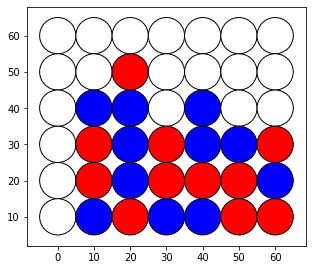

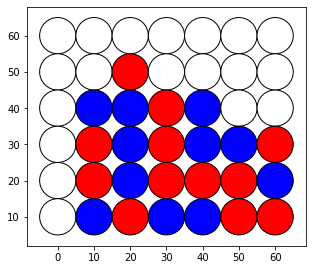

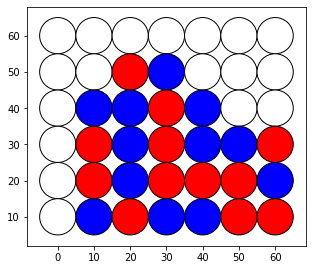

2021-01-19 01:57:52.941311
[1, 0, 0]


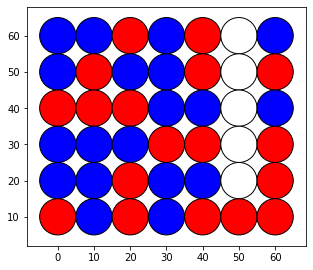

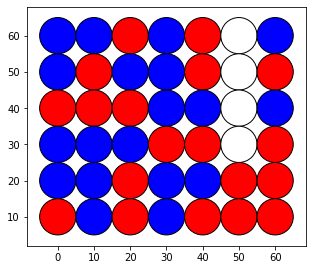

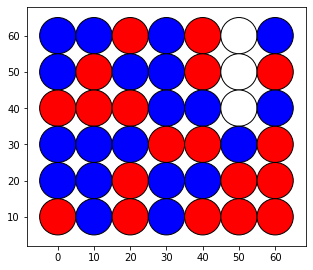

2021-01-19 02:01:04.199068
[2, 0, 0]


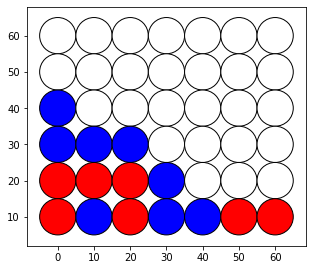

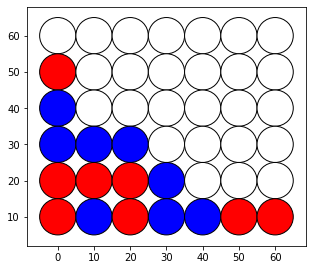

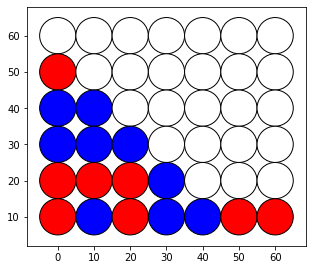

2021-01-19 02:02:24.924563
[3, 0, 0]


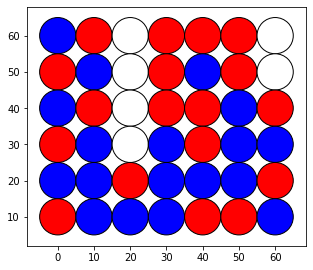

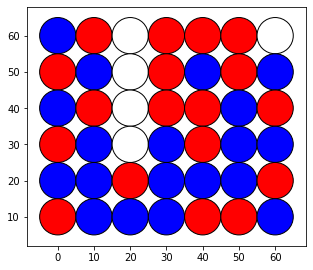

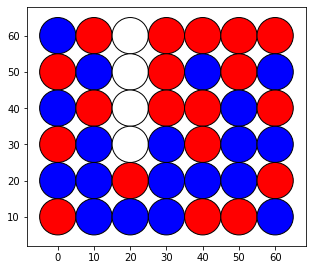

2021-01-19 02:05:36.109306
[3, 0, 1]


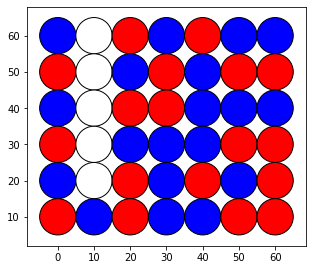

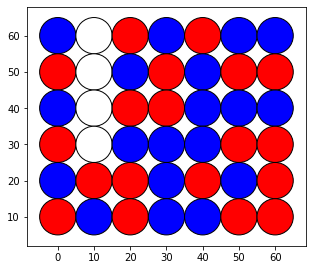

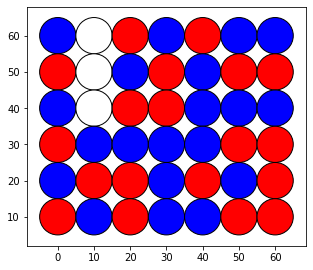

2021-01-19 02:08:47.351735
[4, 0, 1]


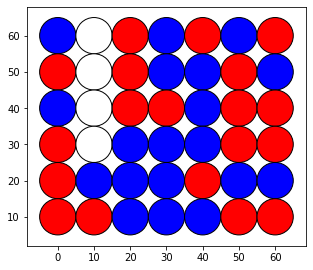

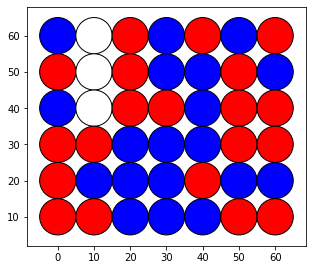

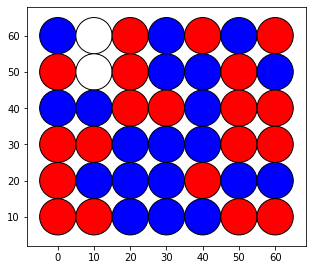

2021-01-19 02:11:58.550147
[5, 0, 1]


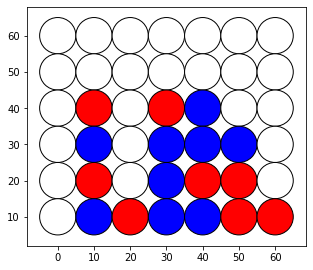

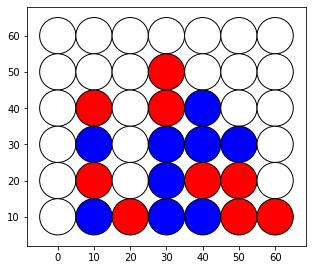

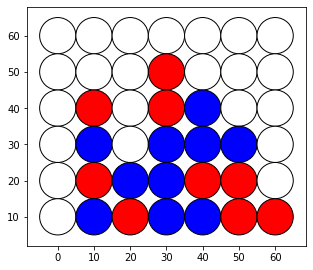

2021-01-19 02:13:29.398217
[6, 0, 1]


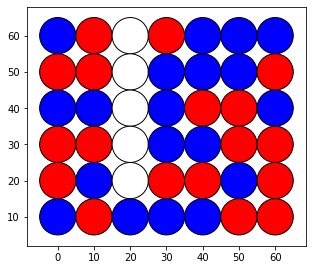

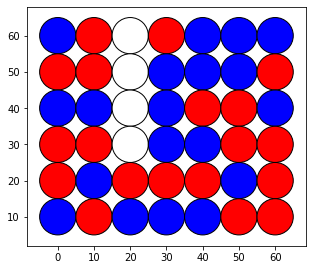

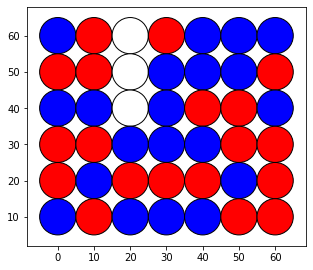

2021-01-19 02:16:40.579020
[7, 0, 1]


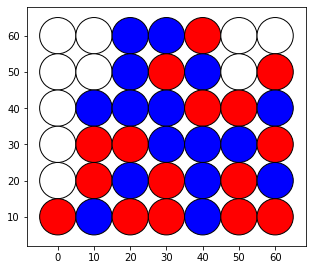

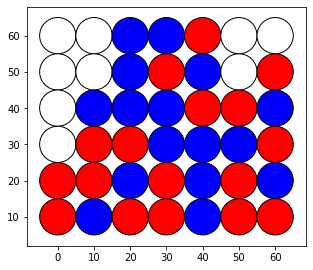

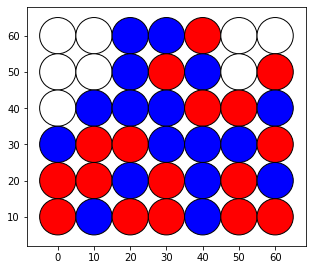

2021-01-19 02:19:21.708974
[8, 0, 1]


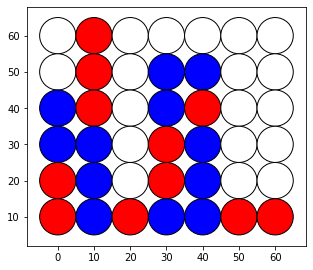

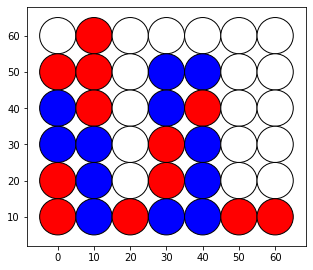

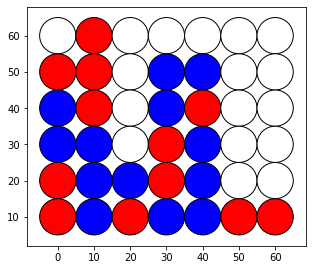

2021-01-19 02:21:22.689124
[9, 0, 1]


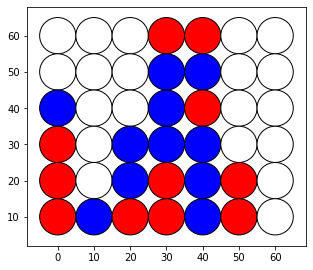

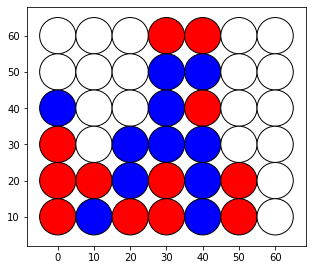

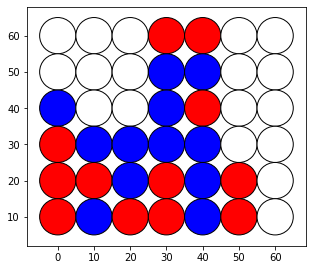

2021-01-19 02:23:13.638690
[10, 0, 1]


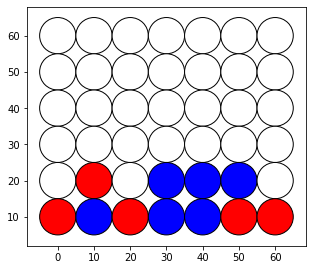

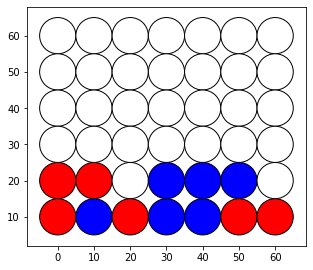

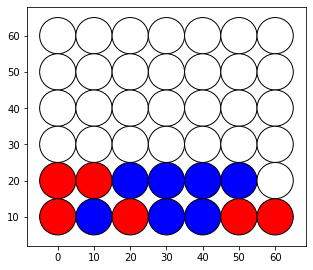

2021-01-19 02:24:14.334199
[11, 0, 1]


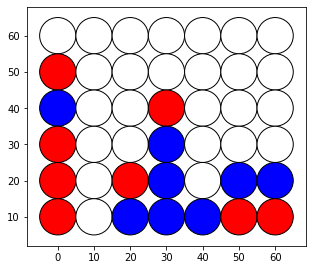

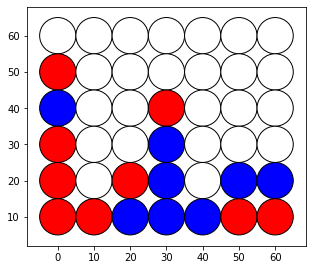

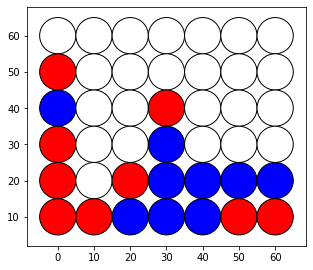

2021-01-19 02:25:35.045334
[12, 0, 1]


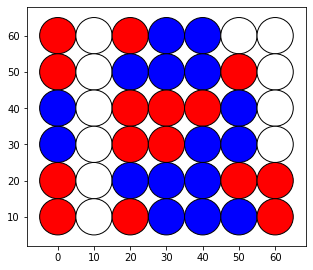

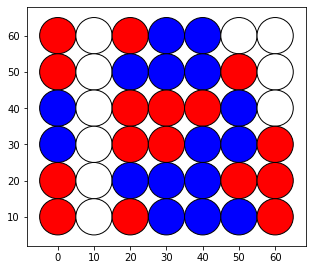

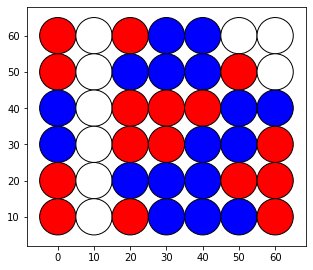

2021-01-19 02:28:16.185778
[13, 0, 1]


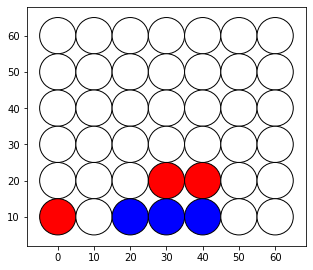

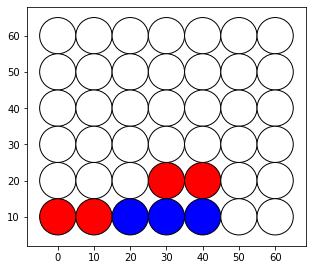

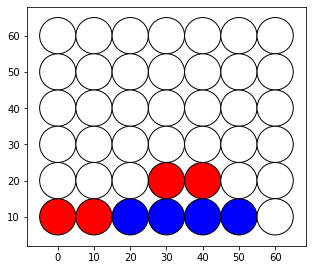

2021-01-19 02:28:46.772486
[14, 0, 1]


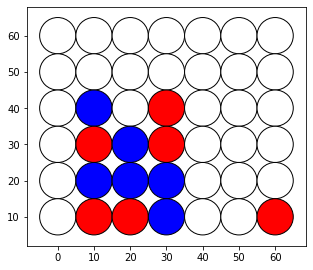

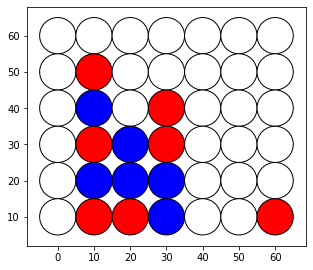

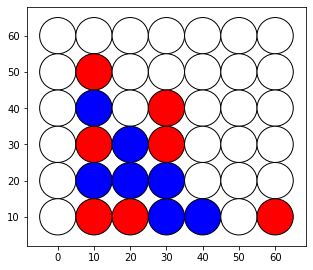

2021-01-19 02:29:47.482637
[15, 0, 1]


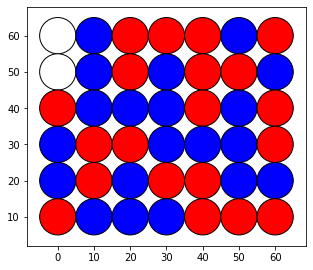

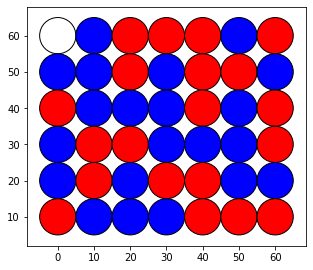

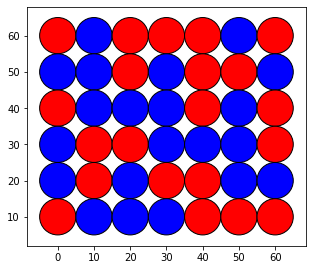

2021-01-19 02:33:18.830370
[15, 1, 1]


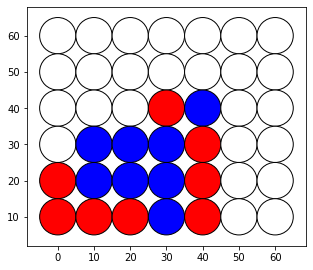

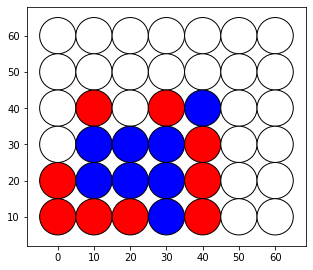

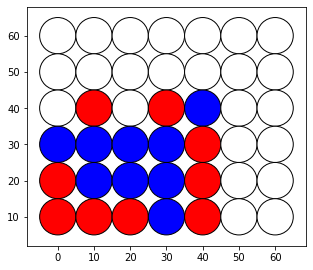

2021-01-19 02:34:39.595227
[16, 1, 1]


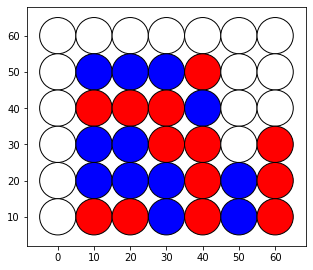

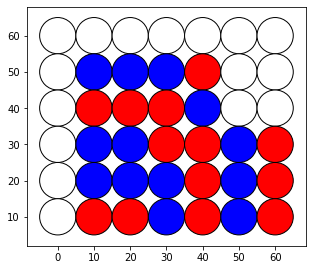

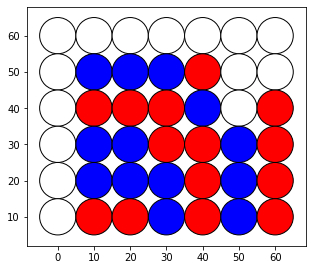

2021-01-19 02:36:50.657016
[16, 1, 2]


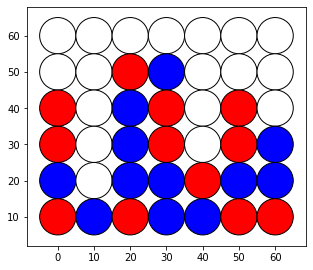

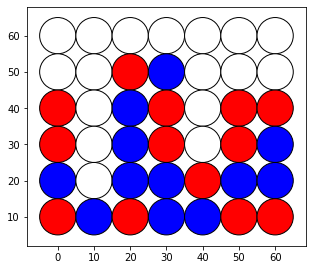

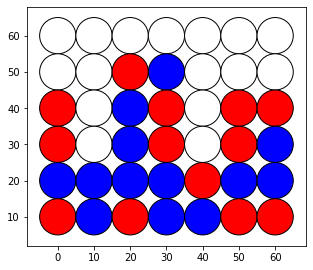

2021-01-19 02:38:51.574674
[17, 1, 2]


In [4]:


battle_limit = 20
battle_count = 0
win_count = [0,0,0]



while battle_count < battle_limit:
    battle_count += 1
    playboard_archive = []

    playboard = initalize_playboard()
    player_turn = random.choice([1,-1])
    winner = 0
    playboard_archive.append(playboard)
    while winner == 0:

        if player_turn == -1:
            playboard_candidate = make_next_playboard_candidate(playboard,player_turn)
            playboard_candidate = [[-1 * playboard_candidate[i][j] for j in range(width * height)]for i in range(len(playboard_candidate))]
            
            if surely_win_board_func(playboard_candidate):
                playboard = surely_win_board_func(playboard_candidate)
                win_count[0] += 1
                winner = -1
                #view_map(playboard)
                
            else:
                
                temp_1,temp_2 = surely_lose_func(playboard_candidate)
                
                
                if len(temp_1) != len(playboard_candidate):
                    for data_ in temp_1:
                        playboard_candidate.remove(data_)
#                        print("=============")
#                        view_map(data_)
#                        print("=============")

                playboard = return_most_valuable(playboard_candidate,think_time=10)
            playboard = [-1 * playboard[i] for i in range(width*height)]
   
        else:
            playboard_candidate = make_next_playboard_candidate(playboard,player_turn)
   
            if surely_win_board_func(playboard_candidate):
                playboard = surely_win_board_func(playboard_candidate)
                win_count[2] += 1
                winner = -1
                #view_map(playboard)
                
            else:
                
                temp_1,temp_2 = surely_lose_func(playboard_candidate)
                
                
                if len(temp_1) != len(playboard_candidate):
                    for data_ in temp_1:
                        playboard_candidate.remove(data_)
#                        print("=============")
#                        view_map(data_)
#                        print("=============")
                        
                playboard = random.choice(playboard_candidate)         
        playboard_archive.append(playboard)
        
        if playboard.count(0) == 0:
            win_count[1] += 1
            break

            
        player_turn *= -1
    
    

    print("=======================")

    
    #最後の３手を可視化
    for i in range(3):
        view_map(playboard_archive[-(3-i)])
    print(datetime.datetime.now())
    print(win_count)
    print("==============================")
    

#    if winner == 1:
#        print("=================================")
#        for i in range(3):
#            print(playboard_archive[-(3-i)])
#            view_map(playboard_archive[-(3-i)])
#            print("----------------------------------")
#        print("================================")    
#        if win_count[2] >= 50:
#            break


    

In [ ]:
#対戦用
playboard = initalize_playboard()
player_turn = random.choice([1,-1])
winner = 0
view_map(playboard)
while winner == 0:

    if player_turn == -1:
        playboard_candidate = make_next_playboard_candidate(playboard,player_turn)
        playboard_candidate = [[-1 * playboard_candidate[i][j] for j in range(width * height)]for i in range(len(playboard_candidate))]

        if surely_win_board_func(playboard_candidate):
            playboard = surely_win_board_func(playboard_candidate)
            winner = -1
            #view_map(playboard)


        else:

            temp_1,temp_2 = surely_lose_func(playboard_candidate)


            if len(temp_1) != len(playboard_candidate):
                for data_ in temp_1:
                    playboard_candidate.remove(data_)
#                        print("=============")
#                        view_map(data_)
#                        print("=============")

            playboard = return_most_valuable(playboard_candidate,think_time=10)
        playboard = [-1 * playboard[i] for i in range(width*height)]
        clear_output()

    else:
        playboard_candidate = make_next_playboard_candidate(playboard,player_turn)
        input_index = int(input("index -> "))
        playboard = playboard_candidate[input_index] 
        if win_or_not(playboard):
            winner = 1
            print("you win!!")

    view_map(playboard)
    
    if playboard.count(0) == 0:
        win_count[1] += 1
        break
        
    player_turn *= -1

if winner == 0:
    print("引き分け")
elif winner == 1:
    print("you win!!")
else:
    print("you lose")
